In [1]:
%run '/Users/itaymi/Desktop/Python/Functions.ipynb'
display(HTML('<style>.container{width:100% !important;}</style>'))

### Import weekly data

In [2]:
data = query("""
    select organizations.organization_id_wh as merchant_id,
           organizations.organization_alias as merchant_name,
           date(format_timestamp('%F', timestamp_trunc(products_usage_tr.action_created_at, week(monday)))) as week,
           coalesce(products_usage_tr.action_type, concat(upper(substr(rapyd_transactions.transaction_action_type, 1, 1)), substr(rapyd_transactions.transaction_action_type, 2))) as action_type,
           count(distinct products_usage_tr.transaction_id_wh) as transactions,
           round(coalesce(cast((sum(distinct (cast(round(coalesce(products_usage_tr.transaction_amount_usd , 0)*(1/1000*1.0), 9) as NUMERIC) + (cast(cast(concat('0x', substr(to_hex(md5(cast(concat(coalesce(products_usage_tr.action_token, ""), coalesce(products_usage_tr.transaction_id_wh , "")) as STRING))), 1, 15)) as int64) as numeric) * 4294967296 + cast(cast(concat('0x', substr(to_hex(md5(cast(concat(coalesce(products_usage_tr.action_token, ""), coalesce(products_usage_tr.transaction_id_wh , "")) as STRING))), 16, 8)) as int64) as numeric)) * 0.000000001)) - sum(distinct (cast(cast(concat('0x', substr(to_hex(md5(cast(concat(coalesce(products_usage_tr.action_token, ""), coalesce(products_usage_tr.transaction_id_wh , "")) as STRING))), 1, 15)) as int64) as numeric) * 4294967296 + cast(cast(concat('0x', substr(to_hex(md5(cast(concat(coalesce(products_usage_tr.action_token, ""), coalesce(products_usage_tr.transaction_id_wh , "")) as STRING))), 16, 8)) as int64) as numeric)) * 0.000000001)) / (1/1000*1.0) as NUMERIC), 0), 6) as tpv_usd
    from looker_wh.organizations organizations
    full join looker_wh.products_usage_tr products_usage_tr on organizations.organization_id = products_usage_tr.org_id_bytes
    left join looker_wh.rapyd_transactions rapyd_transactions on 1 = 2
    where date(products_usage_tr.action_created_at) between date_trunc(current_date(), week(monday)) - interval '12' week 
                                                        and date_trunc(current_date(), week(sunday))
    /* Test    */ and cast(coalesce(organizations.is_test,0) as bool) = false
    /* Korta   */ and cast(coalesce(organizations.organization_is_korta,0) as bool) = false
    /* Neat    */ and cast(coalesce(organizations.organization_is_neat,0) as bool) = false
    /* Moment  */ and coalesce(moment_entity_calc,'0') != 'Moment Holdings Limited'
    /* Valitor */ and cast(coalesce(organizations.is_valitor,false) as bool) = false
    group by 1, 2, 3, 4
    """)

# TPV to numeric
data['tpv_usd'] = pd.to_numeric(data['tpv_usd']).round(2)

# filter & sort
data = data[data.action_type.isin(['Payment','Payout','Card Issuing Auth','Virtual Account'])].sort_values(by = ['week','action_type'], ignore_index = True).copy()

data.head(3)

Execution time = 0:05:50 minutes
------------------------------------
Rows = 7,498 | Columns = 6



,merchant_id,merchant_name,week,action_type,transactions,tpv_usd
0,df60c7f1-c71a-4145-a5ad-ce42e6103319,Kadmos GmbH,2023-11-27,Card Issuing Auth,2487,171066.71
1,None,None,2023-11-27,Card Issuing Auth,0,0.00
2,47933217-e86b-4499-9f81-f3871876f43c,Cornershop,2023-11-27,Card Issuing Auth,2695,167607.79


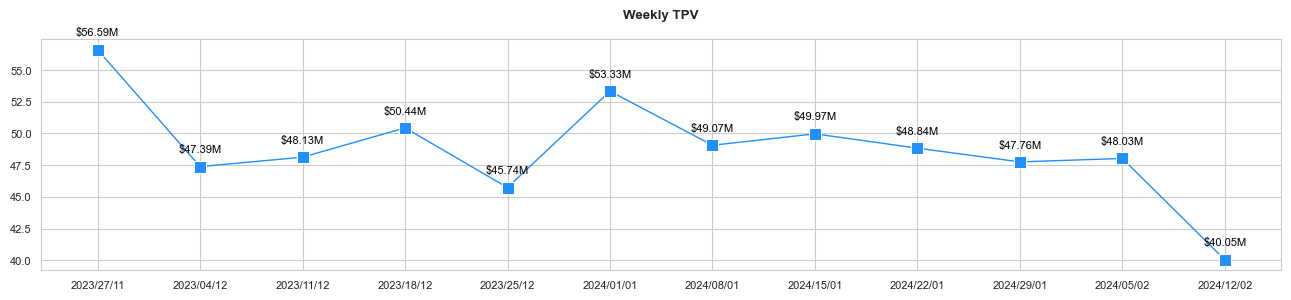

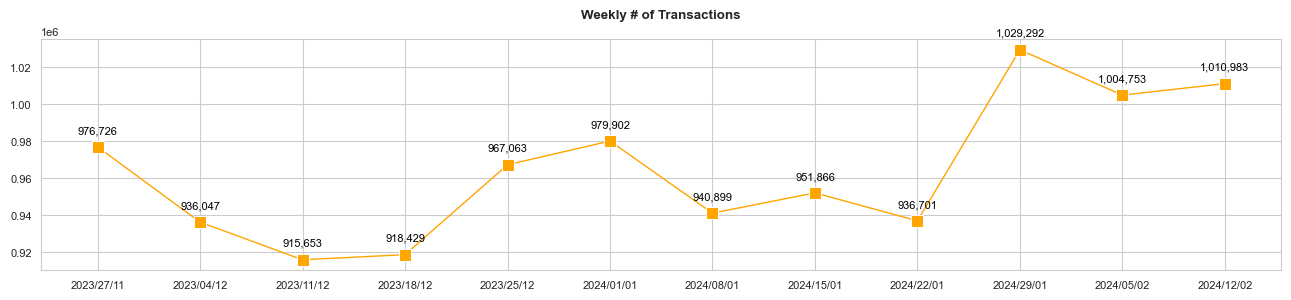

In [3]:
def to_pct(x):
    return round(x * 100, 2)

df = data.copy()

# groupby week
t1 = df.groupby('week', as_index = False).agg({'transactions':'sum','tpv_usd':'sum'})
t1['tpv_usd'] = round(t1['tpv_usd'] / 1_000_000, 2)

import matplotlib.dates as mdates

# lineplot
sns.set_style('whitegrid')
plt.rcParams.update({'figure.figsize':(16,3),'font.size':8})

sns.lineplot(data = t1, x = 'week', y = 'tpv_usd', marker = 's', ms = 8, lw = 1, ci = None, color = 'dodgerblue').set_title('Weekly TPV', weight = 'bold', pad = 15)

for x1,y1 in zip(t1.week.to_numpy(),t1.tpv_usd.to_numpy()):
    plt.annotate(f'${y1}M', (x1,y1), textcoords = 'offset points', xytext = (0,10), ha = 'center', color = 'black', fontsize = 8)
    
plt.ylabel(''), plt.xlabel(''), plt.xticks(rotation = 0)
plt.gca().xaxis.set_major_locator(mdates.WeekdayLocator(byweekday = mdates.MONDAY))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y/%d/%m'))
plt.show()

sns.lineplot(data = t1, x = 'week', y = 'transactions', marker = 's', ms = 8, lw = 1, ci = None, color = 'orange').set_title('Weekly # of Transactions', weight = 'bold', pad = 15)

for x1,y1 in zip(t1.week.to_numpy(),t1.transactions.to_numpy()):
    plt.annotate('{:,.0f}'.format(y1), (x1,y1), textcoords = 'offset points', xytext = (0,10), ha = 'center', color = 'black', fontsize = 8)

plt.ylabel(''), plt.xlabel(''), plt.xticks(rotation = 0)
plt.gca().xaxis.set_major_locator(mdates.WeekdayLocator(byweekday = mdates.MONDAY))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y/%d/%m'))
plt.show()


In [4]:
t1['trxs_change'] = t1.transactions.pct_change()
t1['trxs_change'] = to_pct(t1['trxs_change'].fillna(0))

t1['tpv_change'] = t1.tpv_usd.pct_change()
t1['tpv_change'] = to_pct(t1['tpv_change'].fillna(0))

col = t1.pop('trxs_change')
t1.insert(2, 'trxs_change', col)

t1.style.background_gradient(subset = ['trxs_change','tpv_change'], cmap = 'seismic_r', axis = 0).format(precision = 2)

,week,transactions,trxs_change,tpv_usd,tpv_change
0,2023-11-27,976726,0.00,56.59,0.00
1,2023-12-04,936047,-4.16,47.39,-16.26
2,2023-12-11,915653,-2.18,48.13,1.56
3,2023-12-18,918429,0.30,50.44,4.80
4,2023-12-25,967063,5.30,45.74,-9.32
5,2024-01-01,979902,1.33,53.33,16.59
6,2024-01-08,940899,-3.98,49.07,-7.99
7,2024-01-15,951866,1.17,49.97,1.83
8,2024-01-22,936701,-1.59,48.84,-2.26
9,2024-01-29,1029292,9.88,47.76,-2.21


### Per Action Type

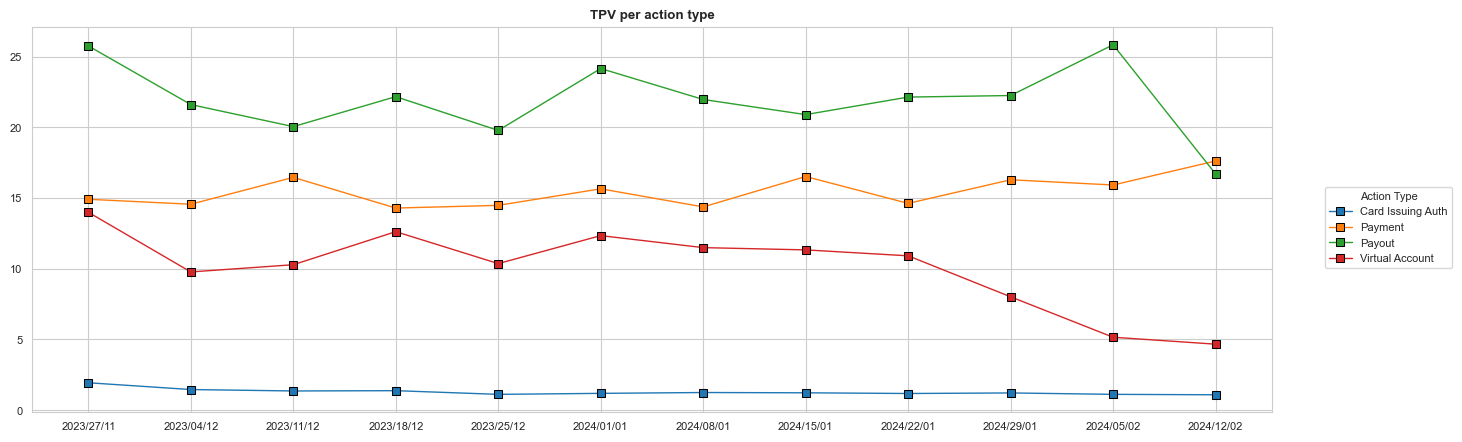

In [5]:
# groupby week & action
t2 = df.groupby(['week','action_type'], as_index = False).agg({'transactions':'sum','tpv_usd':'sum'})
t2['tpv_usd'] = round(t2['tpv_usd'] / 1_000_000, 2)

plt.rcParams.update({'figure.figsize':(16,5),'font.size':8})

sns.lineplot(data = t2, x = 'week', y = 'tpv_usd', ci = None, hue = 'action_type', marker = 's', ms = 6, lw = 1, mec = 'black').set_title('TPV per action type', weight = 'bold')

plt.ylabel(''), plt.xlabel(''), plt.xticks(rotation = 0)
plt.gca().xaxis.set_major_locator(mdates.WeekdayLocator(byweekday = mdates.MONDAY))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y/%d/%m'))

plt.legend(bbox_to_anchor = [1.15,0.6], title = 'Action Type');

In [6]:
t2['tpv_change'] = t2.groupby('action_type').tpv_usd.transform('pct_change')
t2['tpv_change'] = to_pct(t2['tpv_change'])

t2['tpv_abs_change'] = t2.groupby('action_type').tpv_usd.transform('diff')

print('Weekly TPV change in %, per action')

pd.pivot_table(data = t2, index = 'action_type', columns = 'week', values = 'tpv_change', aggfunc = 'sum', fill_value = 0).\
   style.background_gradient(cmap = 'seismic_r', axis = None).format(precision = 2)

Weekly TPV change in %, per action


week,2023-11-27,2023-12-04,2023-12-11,2023-12-18,2023-12-25,2024-01-01,2024-01-08,2024-01-15,2024-01-22,2024-01-29,2024-02-05,2024-02-12
action_type,,,,,,,,,,,,
Card Issuing Auth,0.00,-24.87,-6.90,1.48,-18.98,6.31,5.08,-1.61,-4.10,3.42,-8.26,-2.70
Payment,0.00,-2.35,13.05,-13.18,1.33,8.08,-8.18,14.96,-11.50,11.42,-2.27,10.68
Payout,0.00,-16.11,-7.22,10.57,-10.78,22.14,-9.06,-4.87,5.93,0.50,16.13,-35.37
Virtual Account,0.00,-30.16,5.22,22.76,-17.91,19.11,-6.89,-1.39,-3.71,-26.58,-35.71,-9.51


In [7]:
print('Weekly TPV change in absolute values (Millions), per action')

pd.pivot_table(data = t2, index = 'action_type', columns = 'week', values = 'tpv_abs_change', aggfunc = 'sum', fill_value = 0).\
   style.background_gradient(cmap = 'seismic_r', axis = None).format(precision = 2)

Weekly TPV change in absolute values (Millions), per action


week,2023-11-27,2023-12-04,2023-12-11,2023-12-18,2023-12-25,2024-01-01,2024-01-08,2024-01-15,2024-01-22,2024-01-29,2024-02-05,2024-02-12
action_type,,,,,,,,,,,,
Card Issuing Auth,0.00,-0.48,-0.10,0.02,-0.26,0.07,0.06,-0.02,-0.05,0.04,-0.10,-0.03
Payment,0.00,-0.35,1.90,-2.17,0.19,1.17,-1.28,2.15,-1.90,1.67,-0.37,1.70
Payout,0.00,-4.15,-1.56,2.12,-2.39,4.38,-2.19,-1.07,1.24,0.11,3.59,-9.14
Virtual Account,0.00,-4.22,0.51,2.34,-2.26,1.98,-0.85,-0.16,-0.42,-2.90,-2.86,-0.49


In [8]:
########################
action_type = 'Payout'
########################

df3 = df[df.action_type == action_type].reset_index(drop = True).copy()

print(f'Unique merchants ({action_type}s) = {df3.merchant_id.nunique():,}')

df3_all = df3.groupby(['action_type','merchant_id','merchant_name'], as_index = False)['tpv_usd'].sum().sort_values(by = 'tpv_usd', ascending = False, ignore_index = True)

df3_all['pct_total']  = to_pct(df3_all['tpv_usd'] / df3_all['tpv_usd'].sum())
df3_all['pct_cumsum'] = df3_all['pct_total'].cumsum()

df3_all.head(3)

Unique merchants (Payouts) = 62


,action_type,merchant_id,merchant_name,tpv_usd,pct_total,pct_cumsum
0,Payout,b08ac12b-7d55-4e08-ae5f-ef86327bdd71,Hotmart,63846846.17,24.25,24.25
1,Payout,0e97428e-1ec3-4b56-9163-3acb5f3352e4,SingX Singapore Pte Ltd,39280721.72,14.92,39.17
2,Payout,0b049288-cfd6-49c0-8727-e99e82506b86,Ontop Holdings Inc,22056374.03,8.38,47.55


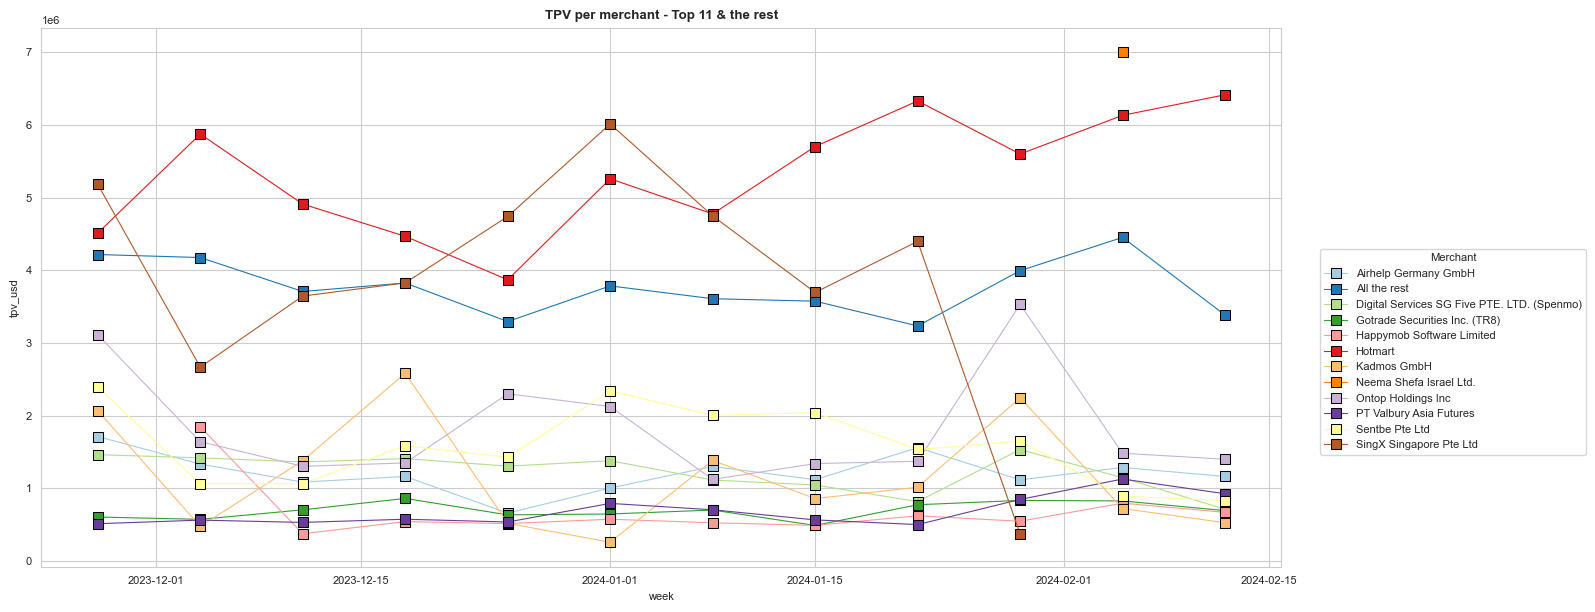

In [9]:
#################
num_leaders = 11
#################

# entire time period leaders
threshold = df3_all.at[num_leaders - 1, 'pct_total']
df3_all['merchant'] = np.where(df3_all['pct_total'] >= threshold, df3_all['merchant_name'], 'All the rest')

# embed in the original dataframe
leaders = df3_all.merchant.unique()[:-1]
df3['merchant'] = np.where(df3.merchant_name.isin(leaders), df3['merchant_name'], 'All the rest')

df4 = df3.groupby(['merchant','week'], as_index = False).tpv_usd.sum()

plt.rcParams.update({'figure.figsize':(16,7),'font.size':8})
                            
sns.lineplot(data = df4, x = 'week', y = 'tpv_usd', ci = None, hue = 'merchant', marker = 's', ms = 7, lw = .8, palette = 'Paired', mec = 'black').\
    set_title(f'TPV per merchant - Top {num_leaders} & the rest', weight = 'bold')
plt.legend(bbox_to_anchor = [1.25,0.6], title = 'Merchant');

In [10]:
df4['tpv_change'] = df4.groupby('merchant').tpv_usd.transform('pct_change')
df4['tpv_change'] = to_pct(df4['tpv_change'])

df4['weekly_total_tpv'] = df4.groupby('week').tpv_usd.transform('sum')
df4['pct_of_week'] = to_pct(df4['tpv_usd'] / df4['weekly_total_tpv'])

df4.head(3)

,merchant,week,tpv_usd,tpv_change,weekly_total_tpv,pct_of_week
0,Airhelp Germany GmbH,2023-11-27,1710509.34,NaN,25759855.58,6.64
1,Airhelp Germany GmbH,2023-12-04,1330925.27,-22.19,21612126.54,6.16
2,Airhelp Germany GmbH,2023-12-11,1083218.40,-18.61,20048356.65,5.40


In [11]:
print('Weekly TPV weight per merchant')

pd.pivot_table(data = df4, index = 'merchant', columns = 'week', values = 'pct_of_week', aggfunc = 'sum', fill_value = 0).\
   style.background_gradient(cmap = 'winter_r', axis = 0).format(precision = 2)

Weekly TPV weight per merchant


week,2023-11-27,2023-12-04,2023-12-11,2023-12-18,2023-12-25,2024-01-01,2024-01-08,2024-01-15,2024-01-22,2024-01-29,2024-02-05,2024-02-12
merchant,,,,,,,,,,,,
Airhelp Germany GmbH,6.64,6.16,5.40,5.24,3.32,4.15,5.91,5.34,7.03,5.01,4.97,6.95
All the rest,16.37,19.32,18.49,17.25,16.65,15.66,16.42,17.10,14.60,17.95,17.23,20.26
Digital Services SG Five PTE. LTD. (Spenmo),5.67,6.56,6.79,6.35,6.59,5.70,5.06,4.99,3.68,6.88,4.42,4.24
Gotrade Securities Inc. (TR8),2.34,2.64,3.50,3.87,3.20,2.67,3.18,2.33,3.49,3.74,3.19,4.13
Happymob Software Limited,0.00,8.54,1.86,2.44,2.59,2.37,2.38,2.33,2.80,2.45,3.07,4.00
Hotmart,17.52,27.18,24.49,20.15,19.56,21.76,21.74,27.29,28.60,25.17,23.73,38.42
Kadmos GmbH,8.02,2.19,6.88,11.64,2.61,1.06,6.29,4.10,4.58,10.09,2.78,3.14
Neema Shefa Israel Ltd.,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,27.09,0.00
Ontop Holdings Inc,12.07,7.59,6.48,6.08,11.63,8.79,5.10,6.40,6.19,15.86,5.73,8.37


In [12]:
print('Weekly TPV change in %, per merchant')

pd.pivot_table(data = df4, index = 'merchant', columns = 'week', values = 'tpv_change', aggfunc = 'sum').\
   style.background_gradient(cmap = 'seismic_r', axis = None).format(precision = 2)

Weekly TPV change in %, per merchant


week,2023-11-27,2023-12-04,2023-12-11,2023-12-18,2023-12-25,2024-01-01,2024-01-08,2024-01-15,2024-01-22,2024-01-29,2024-02-05,2024-02-12
merchant,,,,,,,,,,,,
Airhelp Germany GmbH,0.00,-22.19,-18.61,7.20,-43.48,52.70,29.59,-14.01,39.42,-28.42,15.23,-9.60
All the rest,0.00,-0.99,-11.20,3.16,-13.89,14.91,-4.66,-0.94,-9.55,23.55,11.47,-24.03
Digital Services SG Five PTE. LTD. (Spenmo),0.00,-2.98,-3.95,3.38,-7.44,5.79,-19.32,-6.13,-21.94,87.99,-25.41,-37.94
Gotrade Securities Inc. (TR8),0.00,-5.36,23.01,22.37,-26.39,1.98,8.36,-30.36,58.64,7.70,-0.82,-16.24
Happymob Software Limited,nan,0.00,-79.83,45.15,-5.20,11.77,-8.57,-6.78,27.04,-12.17,45.75,-15.89
Hotmart,0.00,30.18,-16.41,-9.03,-13.40,35.94,-9.20,19.44,11.00,-11.54,9.51,4.62
Kadmos GmbH,0.00,-77.09,191.45,87.16,-80.02,-50.41,440.24,-37.96,18.18,121.59,-67.95,-27.10
Neema Shefa Israel Ltd.,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,0.00,nan
Ontop Holdings Inc,0.00,-47.27,-20.72,3.64,70.67,-7.64,-47.24,19.44,2.34,157.68,-58.05,-5.57


### WoW Influence

In [13]:
prev_week, last_week = np.sort(df4.week.unique())[-2:]

df5 = df4[df4.week.isin([prev_week,last_week])].reset_index(drop = True).copy()

df5_piv = pd.pivot_table(data = df5, index = 'merchant', columns = 'week', values = 'tpv_usd', aggfunc = 'sum', fill_value = 0).\
          astype(int).reset_index()

prev_week_total  = df4[df4.week == prev_week].tpv_usd.sum()
last_week_total  = df4[df4.week == last_week].tpv_usd.sum()
total_abs_change = last_week_total - prev_week_total

df5_piv['actual_change'] = df5_piv.iloc[:,-1] - df5_piv.iloc[:,-2]

df5_piv['influence'] = np.abs(df5_piv.actual_change) / df5_piv['actual_change'].abs().sum()
df5_piv['influence'] = to_pct(df5_piv['influence'])

print(f'Weekly change (Wow) = ${int(total_abs_change):,}')

df5_piv.sort_values(by = 'influence', ascending = False).set_index('merchant').style.background_gradient(subset = ['actual_change','influence'], cmap = 'winter_r', axis = 0).format({'influence': '{:.2f}%'})

Weekly change (Wow) = $-9,146,014


week,2024-02-05,2024-02-12,actual_change,influence
merchant,,,,
Neema Shefa Israel Ltd.,7001000,0,-7001000,72.08%
All the rest,4452127,3382407,-1069720,11.01%
Digital Services SG Five PTE. LTD. (Spenmo),1142207,708804,-433403,4.46%
Hotmart,6132292,6415405,283113,2.92%
PT Valbury Asia Futures,1125812,922669,-203143,2.09%
Kadmos GmbH,719295,524370,-194925,2.01%
Gotrade Securities Inc. (TR8),824288,690420,-133868,1.38%
Happymob Software Limited,793281,667261,-126020,1.30%
Airhelp Germany GmbH,1284203,1160948,-123255,1.27%
